In [1]:
%matplotlib inline

import os

from IPython.display import Image
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
import geohash2
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation, Masking
from keras.layers.recurrent import LSTM
from keras.layers import Flatten, Embedding

Using TensorFlow backend.


In [18]:
# Read in all Atlantic hurricane data
hurricanes = pd.read_csv('../data/atlantic_hurricanes.csv')

# Create a date column and only use hurricanes since 1990
hurricanes['Date'] = pd.to_datetime(hurricanes['Date'], errors='coerce')
hurricanes.dropna(inplace=True)
hurricanes['year'] = hurricanes['Date'].dt.year.astype(int)
hurricanes = hurricanes[hurricanes['year'] >= 1990]
hurricanes = hurricanes[hurricanes['Name'] != 'Unnamed']

# ETL to make lat/long correct, and convert them to shapely points
hurricanes['slug'] = hurricanes['Name'] + '-' + hurricanes['year'].astype(str)
hurricanes['Long'] = 0 - hurricanes['Long']
hurricanes['coordinates'] = hurricanes[['Long', 'Lat']].values.tolist()
hurricanes['coordinates'] = hurricanes['coordinates'].apply(Point)

# Extract the movement speed of the hurricane as a feature
hurricanes['movement_speed'] = hurricanes['Movement'].str.extract(r'(\d+)\s?[mph|MPH]')
hurricanes.fillna(value=0, inplace=True)

# Create geohashes from the lat/long for use in modeling
geohashes = []

for index,row in hurricanes.iterrows():
    latitude = row['coordinates'].x
    longitude = row['coordinates'].y
    geohash = geohash2.encode(
        latitude=latitude, 
        longitude=longitude, 
        precision=5
    )
    geohashes.append(geohash)
    
hurricanes['geohash'] = geohashes
n_classes = len(set(hurricanes['geohash']))

label_encoder = preprocessing.LabelEncoder()
min_max_scaler = preprocessing.MinMaxScaler()

# Encode the geohash labels as integers
hurricanes['encoded_label'] = label_encoder.fit_transform(hurricanes['geohash'])

In [19]:
features = ['Lat', 'Long', 'Wind', 'Pres', 'movement_speed']
label = 'encoded_label'
test_slug = 'Katrina-2005'

# Scale the input data between 0-1
for feature in features:
    values = hurricanes[feature].values
    hurricanes[feature] = min_max_scaler.fit_transform(
        values.reshape(-1, 1)
    )

pre_train_x = []
pre_train_y = []

pre_test_x = []
pre_test_y = []

# Create tensors of the feature and labels
for name, group in hurricanes.groupby('slug'):
    temp_df = hurricanes[hurricanes['slug'] == name]
    if name == test_slug:
        pre_test_x.append(temp_df[features].to_numpy())
        pre_test_y.append(temp_df[label].to_numpy())
    if len(temp_df) >= 40:
        pre_train_x.append(temp_df[features].to_numpy())
        pre_train_y.append(temp_df[label].to_numpy())

In [34]:
# All of the hurricanes paths need to be the same length
# We can use a kera tool to do this.
def pad_sequence(data):
    padded = pad_sequences(
        sequences=data,
        maxlen=50,
        dtype='object',
        padding='post',
        truncating='pre',
        value=0.0
    )
                   
    return padded

# Build the layer structures of the RNN
def build_structure():
    model = Sequential()
    
    model.add(LSTM(
        units=300,
        input_shape=(50, 5),
        activation='relu', 
        recurrent_activation='hard_sigmoid', 
        return_sequences=True,
        dropout=0.1,
        recurrent_dropout=0.1
    ))
        
    # Output layer
    model.add(Dense(
        units=n_classes, 
        activation='softmax'
    ))

    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='Adagrad',
        metrics=['categorical_accuracy']
    )
    
    return model

In [21]:
post_train_x = pad_sequence(data=pre_train_x)
post_train_y = pad_sequence(data=pre_train_y)
post_train_y = post_train_y.reshape(
    np.shape(pre_train_x)[0], 50, 1
)
post_test_x = pad_sequence(data=pre_test_x)
post_test_y = pad_sequence(data=pre_test_y)
post_test_y = post_test_y.reshape(1, 50, 1)

In [35]:
model = build_structure()
model.fit(
    x=post_train_x,
    y=post_train_y,
    epochs=10,
    verbose=2,
    validation_split=0.3
)

Train on 74 samples, validate on 33 samples
Epoch 1/10
 - 3s - loss: 10.0848 - categorical_accuracy: 0.5600 - val_loss: 14.4575 - val_categorical_accuracy: 0.7703
Epoch 2/10
 - 2s - loss: 12.3965 - categorical_accuracy: 0.6732 - val_loss: 9.3666 - val_categorical_accuracy: 0.0000e+00
Epoch 3/10
 - 2s - loss: 9.2880 - categorical_accuracy: 0.0000e+00 - val_loss: 12.0730 - val_categorical_accuracy: 0.4236
Epoch 4/10
 - 2s - loss: 10.0741 - categorical_accuracy: 0.1843 - val_loss: 9.3850 - val_categorical_accuracy: 0.0036
Epoch 5/10
 - 2s - loss: 9.2306 - categorical_accuracy: 0.0141 - val_loss: 9.4111 - val_categorical_accuracy: 0.0970
Epoch 6/10
 - 2s - loss: 9.9650 - categorical_accuracy: 0.3251 - val_loss: 9.3989 - val_categorical_accuracy: 0.0000e+00
Epoch 7/10
 - 2s - loss: 9.1858 - categorical_accuracy: 0.0024 - val_loss: 9.4139 - val_categorical_accuracy: 0.0048
Epoch 8/10
 - 2s - loss: 9.2588 - categorical_accuracy: 0.0173 - val_loss: 9.4030 - val_categorical_accuracy: 0.0170
Epo

In [36]:
model.predict_classes(post_test_x)

array([[11149, 10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829,
        10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829,
        10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829,
        10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829,
        10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829, 10829,
        10829, 10829, 10829, 10829, 10829]])

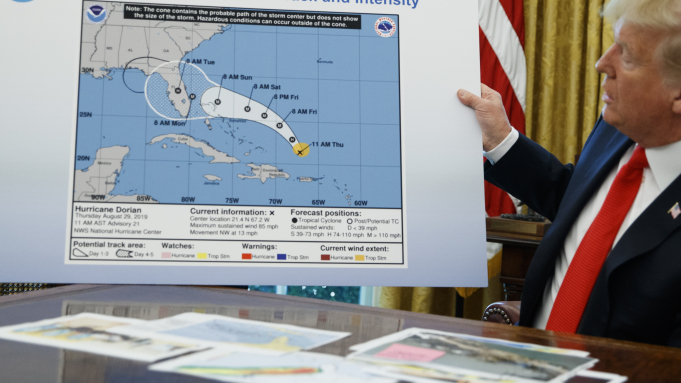

In [3]:
Image('../data/ap_19247710623631.jpg')